In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import PoissonRegressor, Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor

## Question 1: Top 10 Bundesliga teams over entire period

**Metric: Points Per Game (PPG)**
- 3 points for win
- 1 point for draw
- 0 points for loss

In [2]:
# Load data
df = pd.read_csv('data/bundesliga.csv')

# Convert Date to datetime 
df['Date'] = pd.to_datetime(df['Date'], format='mixed', dayfirst=True)

# Quick look
print(f"Dataset shape: {df.shape}")
print(f"\nDate range: {df['Date'].min()} to {df['Date'].max()}")
df.head()

Dataset shape: (7650, 11)

Date range: 1993-08-07 00:00:00 to 2018-05-12 00:00:00


,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Season
0,D1,1993-08-07,Bayern Munich,Freiburg,3,1,H,NaN,NaN,NaN,1993-94
1,D1,1993-08-07,Dortmund,Karlsruhe,2,1,H,NaN,NaN,NaN,1993-94
2,D1,1993-08-07,Duisburg,Leverkusen,2,2,D,NaN,NaN,NaN,1993-94
3,D1,1993-08-07,FC Koln,Kaiserslautern,0,2,A,NaN,NaN,NaN,1993-94
4,D1,1993-08-07,Hamburg,Nurnberg,5,2,H,NaN,NaN,NaN,1993-94


In [3]:
# Check for missing values
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 7650 entries, 0 to 7649
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Div       7650 non-null   str           
 1   Date      7650 non-null   datetime64[us]
 2   HomeTeam  7650 non-null   str           
 3   AwayTeam  7650 non-null   str           
 4   FTHG      7650 non-null   int64         
 5   FTAG      7650 non-null   int64         
 6   FTR       7650 non-null   str           
 7   HTHG      7038 non-null   float64       
 8   HTAG      7038 non-null   float64       
 9   HTR       7038 non-null   str           
 10  Season    7650 non-null   str           
dtypes: datetime64[us](1), float64(2), int64(2), str(6)
memory usage: 657.6 KB


## Calculate Points for Each Team

In [4]:
def calculate_team_stats(df):
    stats = {}
    
    # Process matches
    for _, row in df.iterrows():
        home_team = row['HomeTeam']
        away_team = row['AwayTeam']
        result = row['FTR']
        
        # Initialize teams if not seen before
        if home_team not in stats:
            stats[home_team] = {'games': 0, 'points': 0}
        if away_team not in stats:
            stats[away_team] = {'games': 0, 'points': 0}
        
        # Update home team stats
        stats[home_team]['games'] += 1
        
        if result == 'H': 
            stats[home_team]['points'] += 3
        elif result == 'D':     
            stats[home_team]['points'] += 1
        
        # Update away team stats
        stats[away_team]['games'] += 1
        
        if result == 'A': 
            stats[away_team]['points'] += 3
        elif result == 'D':     
            stats[away_team]['points'] += 1
    
    return stats

In [5]:
# Calculate stats
team_stats = calculate_team_stats(df)

# Convert to df
stats_df = pd.DataFrame.from_dict(team_stats, orient='index')
stats_df.index.name = 'Team'
stats_df.reset_index(inplace=True)

# Calculate derived metrics
stats_df['PPG'] = stats_df['points'] / stats_df['games']

print(f"Total teams in dataset: {len(stats_df)}")
stats_df.head()

Total teams in dataset: 43


,Team,games,points,PPG
0,Bayern Munich,850,1820,2.141176
1,Freiburg,612,719,1.174837
2,Dortmund,850,1472,1.731765
3,Karlsruhe,238,306,1.285714
4,Duisburg,272,292,1.073529


In [6]:
# Filter teams with min 100 games and get top 10
min_games = 100

filtered_stats = stats_df[stats_df['games'] >= min_games]
top_10 = filtered_stats.sort_values('PPG', ascending=False).head(10)

print(f"=== TOP 10 BUNDESLIGA TEAMS (1993-2018) ===")
print(f"Filtered by minimum {min_games} games | Teams remaining: {len(filtered_stats)}\n")

# Reset index to start from 1
top_10_display = top_10[['Team', 'games', 'PPG']].reset_index(drop=True)
top_10_display.index = range(1, 11)
top_10_display

=== TOP 10 BUNDESLIGA TEAMS (1993-2018) ===
Filtered by minimum 100 games | Teams remaining: 27



,Team,games,PPG
1,Bayern Munich,850,2.141176
2,Dortmund,850,1.731765
3,Leverkusen,850,1.664706
4,Schalke 04,850,1.568235
5,Werder Bremen,850,1.494118
6,Stuttgart,816,1.441176
7,Kaiserslautern,476,1.394958
8,Hertha,646,1.385449
9,Wolfsburg,714,1.379552
10,Hamburg,850,1.350588


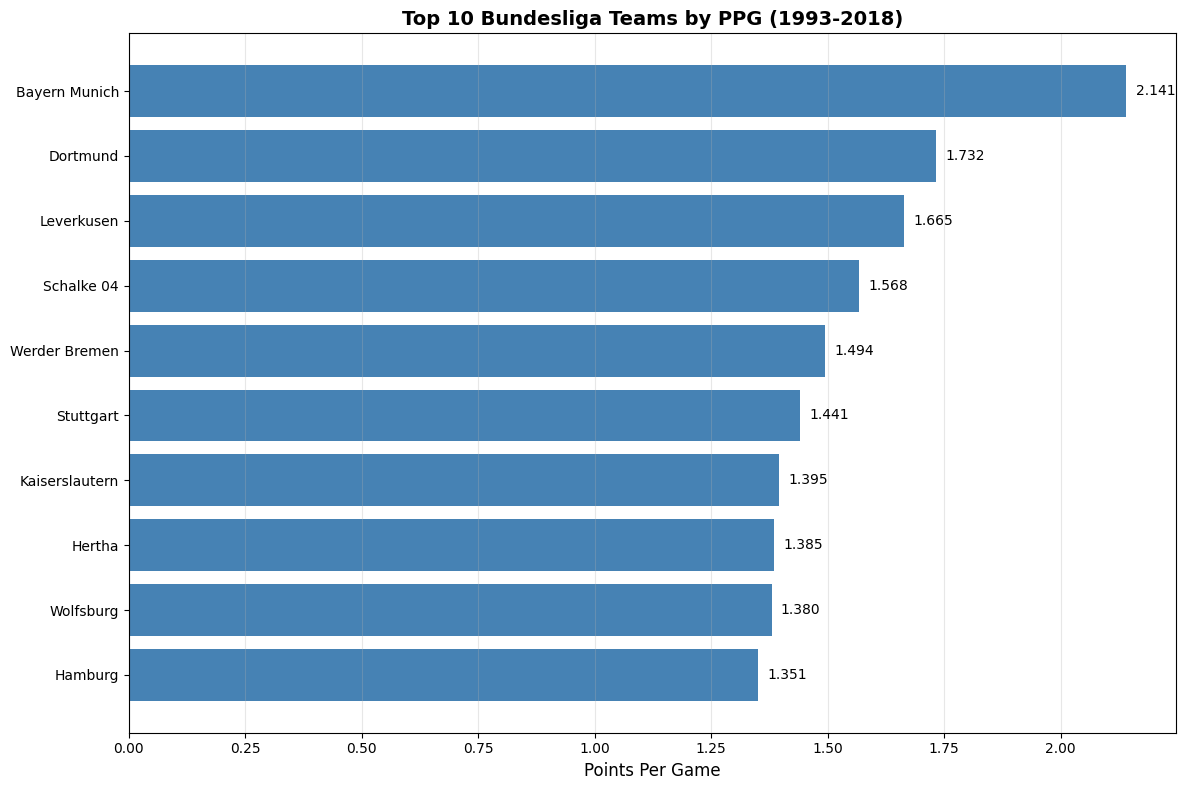

In [7]:
# Bar chart of top 10 teams
fig, ax = plt.subplots(figsize=(12, 8))

# PPG comparison
ax.barh(range(len(top_10)), top_10['PPG'].values, color='steelblue')
ax.set_yticks(range(len(top_10)))
ax.set_yticklabels(top_10['Team'].values)
ax.set_xlabel('Points Per Game', fontsize=12)
ax.set_title('Top 10 Bundesliga Teams by PPG (1993-2018)', fontsize=14, fontweight='bold')
ax.invert_yaxis()
ax.grid(axis='x', alpha=0.3)

# Add value labels
for i, v in enumerate(top_10['PPG'].values):
    ax.text(v + 0.02, i, f'{v:.3f}', va='center', fontsize=10)

plt.tight_layout()
plt.show()

### Summary - Question 1

**Approach:**
The chosen metric is points per game (PPG) using FIFA's 3-1-0 point system (3 for win, 1 for draw, 0 for loss) mirroring reality and preventing skews due to draws. A filter of minimum 100 games is placed to ensure statistical significance and exclude short term performance as 2 teams initially placed in the top 10 without this constraint. The complete dataset is covered from 1993 to 2018.

**Key Findings:**
Bayern Munich dominates with 2.141 PPG, significantly ahead of other teams. Other established Bundesliga teams cluster in the 1.5-1.7 range, while the bottom tier consolidates around 1.4. The above horizontal bar chart shows this hierarchy.

## Question 2: Total goals prediction

A model is implemented to predict total goals in football matches. Since bets are placed at half time the target variable for prediction is the total goals in the second half of the matches. 

In [8]:
# Drop rows with missing halftime data (1993/94 and 1994/95 seasons)
df_clean = df.dropna(subset=['HTHG', 'HTAG', 'HTR']).copy()

print(f"\nAfter dropping missing halftime data: {df_clean.shape}")
print(f"Rows dropped: {len(df) - len(df_clean)}")


After dropping missing halftime data: (7038, 11)
Rows dropped: 612


In [9]:
# Target variable: Total goals in second half
df_clean['second_half_goals'] = (df_clean['FTHG'] - df_clean['HTHG']) + (df_clean['FTAG'] - df_clean['HTAG'])
df_clean['year'] = df_clean['Date'].dt.year
df_clean = df_clean.sort_values('Date').reset_index(drop=True)

# Per-team second half stats (for venue-specific rolling)
df_clean['home_sh_goals'] = df_clean['FTHG'] - df_clean['HTHG']
df_clean['away_sh_goals'] = df_clean['FTAG'] - df_clean['HTAG']

# === Halftime context features ===
df_clean['ht_total_goals'] = df_clean['HTHG'] + df_clean['HTAG']
df_clean['ht_goal_diff'] = df_clean['HTHG'] - df_clean['HTAG']
df_clean['ht_home_leading'] = (df_clean['HTHG'] > df_clean['HTAG']).astype(int)
df_clean['ht_away_leading'] = (df_clean['HTAG'] > df_clean['HTHG']).astype(int)
df_clean['ht_draw'] = (df_clean['HTHG'] == df_clean['HTAG']).astype(int)
df_clean['ht_goalless'] = ((df_clean['HTHG'] == 0) & (df_clean['HTAG'] == 0)).astype(int)
df_clean['ht_abs_goal_diff'] = df_clean['ht_goal_diff'].abs()

# === Rolling team form features (overall and venue-specific) ===
def compute_rolling(series, windows=[5, 10]):
    """Compute shifted rolling means with multiple windows."""
    result = {}
    shifted = series.shift(1)
    for w in windows:
        result[w] = shifted.rolling(w, min_periods=1).mean()
    result['exp'] = shifted.expanding(min_periods=1).mean()
    return result

def build_all_rolling_features(df, windows=[5, 10]):
    """Build comprehensive rolling features: overall form + venue-specific form."""
    
    # --- Overall team form (home+away combined) ---
    home = df[['Date', 'HomeTeam', 'FTHG', 'FTAG', 'HTHG', 'HTAG', 'FTR']].copy()
    home.columns = ['Date', 'Team', 'GF', 'GA', 'HTGF', 'HTGA', 'FTR']
    home['is_home'] = 1
    home['match_idx'] = df.index
    home['points'] = home['FTR'].map({'H': 3, 'D': 1, 'A': 0})
    
    away = df[['Date', 'AwayTeam', 'FTAG', 'FTHG', 'HTAG', 'HTHG', 'FTR']].copy()
    away.columns = ['Date', 'Team', 'GF', 'GA', 'HTGF', 'HTGA', 'FTR']
    away['is_home'] = 0
    away['match_idx'] = df.index
    away['points'] = away['FTR'].map({'A': 3, 'D': 1, 'H': 0})
    
    all_matches = pd.concat([home, away]).sort_values(['Team', 'Date']).reset_index(drop=True)
    all_matches['sh_gf'] = all_matches['GF'] - all_matches['HTGF']
    all_matches['sh_ga'] = all_matches['GA'] - all_matches['HTGA']
    all_matches['total_goals'] = all_matches['GF'] + all_matches['GA']
    all_matches['sh_total'] = all_matches['sh_gf'] + all_matches['sh_ga']
    
    grp = all_matches.groupby('Team')
    stats = [('points', 'ppg'), ('GF', 'gf'), ('GA', 'ga'),
             ('sh_gf', 'sh_gf'), ('sh_ga', 'sh_ga'), ('sh_total', 'sh_total'),
             ('total_goals', 'total_goals')]
    
    for col, name in stats:
        for w in windows:
            all_matches[f'roll_{name}_{w}'] = grp[col].transform(
                lambda x: x.shift(1).rolling(w, min_periods=1).mean())
        all_matches[f'exp_{name}'] = grp[col].transform(
            lambda x: x.shift(1).expanding(min_periods=1).mean())
    
    # Split back to home/away
    feature_names = []
    for _, name in stats:
        for w in windows:
            feature_names.append(f'roll_{name}_{w}')
        feature_names.append(f'exp_{name}')
    
    home_feats = all_matches[all_matches['is_home'] == 1][['match_idx'] + feature_names].copy()
    home_feats.columns = ['match_idx'] + [f'home_{f}' for f in feature_names]
    
    away_feats = all_matches[all_matches['is_home'] == 0][['match_idx'] + feature_names].copy()
    away_feats.columns = ['match_idx'] + [f'away_{f}' for f in feature_names]
    
    # --- Venue-specific form (home team at home, away team away) ---
    # Home team: rolling stats from HOME matches only
    home_only = df[['Date', 'HomeTeam', 'FTHG', 'FTAG', 'HTHG', 'HTAG']].copy()
    home_only.columns = ['Date', 'Team', 'GF', 'GA', 'HTGF', 'HTGA']
    home_only['match_idx'] = df.index
    home_only['sh_gf'] = home_only['GF'] - home_only['HTGF']
    home_only['sh_total'] = (home_only['GF'] - home_only['HTGF']) + (home_only['GA'] - home_only['HTGA'])
    
    hgrp = home_only.sort_values(['Team', 'Date']).groupby('Team')
    for w in windows:
        home_only[f'venue_sh_gf_{w}'] = hgrp['sh_gf'].transform(
            lambda x: x.shift(1).rolling(w, min_periods=1).mean())
        home_only[f'venue_sh_total_{w}'] = hgrp['sh_total'].transform(
            lambda x: x.shift(1).rolling(w, min_periods=1).mean())
    
    # Away team: rolling stats from AWAY matches only
    away_only = df[['Date', 'AwayTeam', 'FTAG', 'FTHG', 'HTAG', 'HTHG']].copy()
    away_only.columns = ['Date', 'Team', 'GF', 'GA', 'HTGF', 'HTGA']
    away_only['match_idx'] = df.index
    away_only['sh_gf'] = away_only['GF'] - away_only['HTGF']
    away_only['sh_total'] = (away_only['GF'] - away_only['HTGF']) + (away_only['GA'] - away_only['HTGA'])
    
    agrp = away_only.sort_values(['Team', 'Date']).groupby('Team')
    for w in windows:
        away_only[f'venue_sh_gf_{w}'] = agrp['sh_gf'].transform(
            lambda x: x.shift(1).rolling(w, min_periods=1).mean())
        away_only[f'venue_sh_total_{w}'] = agrp['sh_total'].transform(
            lambda x: x.shift(1).rolling(w, min_periods=1).mean())
    
    venue_home_cols = [f'venue_sh_gf_{w}' for w in windows] + [f'venue_sh_total_{w}' for w in windows]
    venue_home = home_only[['match_idx'] + venue_home_cols].copy()
    venue_home.columns = ['match_idx'] + [f'home_{c}' for c in venue_home_cols]
    
    venue_away_cols = [f'venue_sh_gf_{w}' for w in windows] + [f'venue_sh_total_{w}' for w in windows]
    venue_away = away_only[['match_idx'] + venue_away_cols].copy()
    venue_away.columns = ['match_idx'] + [f'away_{c}' for c in venue_away_cols]
    
    return home_feats, away_feats, venue_home, venue_away

home_feats, away_feats, venue_home, venue_away = build_all_rolling_features(df_clean, windows=[5, 10])

# Merge all features onto df_clean
for feat_df in [home_feats, away_feats, venue_home, venue_away]:
    df_clean = df_clean.merge(feat_df, left_index=True, right_on='match_idx', how='left',
                               suffixes=('', '_DROP'))
    df_clean.drop(columns=[c for c in df_clean.columns if c.endswith('_DROP')], inplace=True)
    if 'match_idx' in df_clean.columns:
        df_clean.drop(columns=['match_idx'], inplace=True)

# === Derived features ===
# Strength differential
for w in [5, 10]:
    df_clean[f'strength_diff_{w}'] = df_clean[f'home_roll_ppg_{w}'] - df_clean[f'away_roll_ppg_{w}']
    df_clean[f'combined_sh_{w}'] = df_clean[f'home_roll_sh_gf_{w}'] + df_clean[f'away_roll_sh_gf_{w}']
    df_clean[f'combined_total_{w}'] = df_clean[f'home_roll_total_goals_{w}'] + df_clean[f'away_roll_total_goals_{w}']
    df_clean[f'combined_sh_conceded_{w}'] = df_clean[f'home_roll_sh_ga_{w}'] + df_clean[f'away_roll_sh_ga_{w}']
    # Venue-specific combined
    df_clean[f'venue_combined_sh_{w}'] = df_clean[f'home_venue_sh_gf_{w}'] + df_clean[f'away_venue_sh_gf_{w}']
    df_clean[f'venue_combined_total_{w}'] = df_clean[f'home_venue_sh_total_{w}'] + df_clean[f'away_venue_sh_total_{w}']

# Expanding combined
df_clean['combined_exp_sh'] = df_clean['home_exp_sh_gf'] + df_clean['away_exp_sh_gf']
# Form trend: 5-game minus 10-game (positive = improving)
df_clean['home_form_trend'] = df_clean['home_roll_ppg_5'] - df_clean['home_roll_ppg_10']
df_clean['away_form_trend'] = df_clean['away_roll_ppg_5'] - df_clean['away_roll_ppg_10']
# Interaction: HT goals * combined SH tendency
df_clean['ht_x_sh_tendency'] = df_clean['ht_total_goals'] * df_clean['combined_sh_10']
# Attack vs defense mismatch (home attack vs away defense, and vice versa)
df_clean['home_attack_vs_away_def'] = df_clean['home_roll_sh_gf_10'] - df_clean['away_roll_sh_ga_10']
df_clean['away_attack_vs_home_def'] = df_clean['away_roll_sh_gf_10'] - df_clean['home_roll_sh_ga_10']

# Assemble final feature list
feature_cols_new = [
    # Halftime context (7)
    'ht_total_goals', 'ht_goal_diff', 'ht_abs_goal_diff',
    'ht_home_leading', 'ht_away_leading', 'ht_draw', 'ht_goalless',
]
# Rolling features per window
for w in [5, 10]:
    feature_cols_new += [
        f'home_roll_ppg_{w}', f'home_roll_gf_{w}', f'home_roll_ga_{w}',
        f'home_roll_sh_gf_{w}', f'home_roll_sh_ga_{w}', f'home_roll_sh_total_{w}',
        f'away_roll_ppg_{w}', f'away_roll_gf_{w}', f'away_roll_ga_{w}',
        f'away_roll_sh_gf_{w}', f'away_roll_sh_ga_{w}', f'away_roll_sh_total_{w}',
        f'home_venue_sh_gf_{w}', f'home_venue_sh_total_{w}',
        f'away_venue_sh_gf_{w}', f'away_venue_sh_total_{w}',
        f'strength_diff_{w}', f'combined_sh_{w}', f'combined_total_{w}',
        f'combined_sh_conceded_{w}',
        f'venue_combined_sh_{w}', f'venue_combined_total_{w}',
    ]
# Expanding + derived
feature_cols_new += [
    'home_exp_sh_gf', 'away_exp_sh_gf', 'combined_exp_sh',
    'home_form_trend', 'away_form_trend',
    'ht_x_sh_tendency',
    'home_attack_vs_away_def', 'away_attack_vs_home_def',
]

print(f"Total features engineered: {len(feature_cols_new)}")
print(f"Rows with any NaN feature: {df_clean[feature_cols_new].isna().any(axis=1).sum()}")
print(f"Total rows: {len(df_clean)}")

Total features engineered: 59
Rows with any NaN feature: 5306
Total rows: 7038


In [10]:
# Split: Train on data before 2016, test on 2016-2018
# Using proper time-series cross-validation within training for hyperparameter selection
train_cutoff_year = 2016
train_df = df_clean[df_clean['year'] < train_cutoff_year].copy()
test_df = df_clean[df_clean['year'] >= train_cutoff_year].copy()

# Impute NaN rolling features with training set medians
train_medians = train_df[feature_cols_new].median()
train_df[feature_cols_new] = train_df[feature_cols_new].fillna(train_medians)
test_df[feature_cols_new] = test_df[feature_cols_new].fillna(train_medians)

print(f"=== Train-Test Split ===")
print(f"Train set: {len(train_df)} matches ({train_df['year'].min()}-{train_df['year'].max()})")
print(f"Test set:  {len(test_df)} matches ({test_df['year'].min()}-{test_df['year'].max()})")

X_train = train_df[feature_cols_new]
y_train = train_df['second_half_goals']
X_test = test_df[feature_cols_new]
y_test = test_df['second_half_goals']

# Also prepare separate targets for dual-target approach
y_train_home = train_df['home_sh_goals']
y_train_away = train_df['away_sh_goals']
y_test_home = test_df['home_sh_goals']
y_test_away = test_df['away_sh_goals']

print(f"\nFeatures: {len(feature_cols_new)}")
print(f"Train SH goals mean: {y_train.mean():.3f} (home: {y_train_home.mean():.3f}, away: {y_train_away.mean():.3f})")
print(f"Test  SH goals mean: {y_test.mean():.3f} (home: {y_test_home.mean():.3f}, away: {y_test_away.mean():.3f})")

# Time-series CV: 3 folds within training data for hyperparameter selection
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=3)
print(f"\nTime-series CV folds:")
for fold, (train_idx, val_idx) in enumerate(tscv.split(X_train)):
    print(f"  Fold {fold+1}: train {len(train_idx)}, val {len(val_idx)}")

=== Train-Test Split ===
Train set: 6273 matches (1995-2015)
Test set:  765 matches (2016-2018)

Features: 59
Train SH goals mean: 1.619 (home: 0.929, away: 0.690)
Test  SH goals mean: 1.590 (home: 0.880, away: 0.710)

Time-series CV folds:
  Fold 1: train 1569, val 1568
  Fold 2: train 3137, val 1568
  Fold 3: train 4705, val 1568


In [11]:
# Baseline model: Predict mean of training set
baseline_pred = np.full(len(y_test), y_train.mean())
baseline_mae = mean_absolute_error(y_test, baseline_pred)
baseline_rmse = np.sqrt(mean_squared_error(y_test, baseline_pred))

print(f"\n=== Baseline (Predict Mean) ===")
print(f"Mean second half goals (train): {y_train.mean():.3f}")
print(f"Test MAE: {baseline_mae:.3f}")
print(f"Test RMSE: {baseline_rmse:.3f}")


=== Baseline (Predict Mean) ===
Mean second half goals (train): 1.619
Test MAE: 1.023
Test RMSE: 1.243


In [12]:
from sklearn.model_selection import TimeSeriesSplit

# === Model 1: Random Forest (original 4-feature baseline) ===
print("=== Model 1: Random Forest (4 features, original setup) ===")
orig_cols = ['ht_total_goals', 'ht_goal_diff', 'home_roll_sh_gf_10', 'away_roll_sh_gf_10']
rf_model = RandomForestRegressor(
    n_estimators=100, max_depth=10,
    min_samples_split=20, min_samples_leaf=10, random_state=42
)
rf_model.fit(X_train[orig_cols], y_train)
rf_pred_test = rf_model.predict(X_test[orig_cols])
rf_mae = mean_absolute_error(y_test, rf_pred_test)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_pred_test))
rf_r2 = r2_score(y_test, rf_pred_test)
print(f"  Test MAE: {rf_mae:.3f}  RMSE: {rf_rmse:.3f}  R²: {rf_r2:.3f}")

# === Model 2: Poisson GLM (all features) ===
print(f"\n=== Model 2: Poisson GLM ({len(feature_cols_new)} features) ===")
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

poisson_glm = PoissonRegressor(alpha=1.0, max_iter=1000)
poisson_glm.fit(X_train_s, y_train)
glm_pred_test = poisson_glm.predict(X_test_s)
glm_mae = mean_absolute_error(y_test, glm_pred_test)
glm_rmse = np.sqrt(mean_squared_error(y_test, glm_pred_test))
glm_r2 = r2_score(y_test, glm_pred_test)
print(f"  Test MAE: {glm_mae:.3f}  RMSE: {glm_rmse:.3f}  R²: {glm_r2:.3f}")

# === Model 3: Ridge Regression ===
print(f"\n=== Model 3: Ridge Regression ({len(feature_cols_new)} features) ===")
ridge = Ridge(alpha=10.0)
ridge.fit(X_train_s, y_train)
ridge_pred_test = ridge.predict(X_test_s)
ridge_mae = mean_absolute_error(y_test, ridge_pred_test)
ridge_rmse = np.sqrt(mean_squared_error(y_test, ridge_pred_test))
ridge_r2 = r2_score(y_test, ridge_pred_test)
print(f"  Test MAE: {ridge_mae:.3f}  RMSE: {ridge_rmse:.3f}  R²: {ridge_r2:.3f}")

# === Model 4: XGBoost Poisson with CV-tuned iterations ===
print(f"\n=== Model 4: XGBoost Poisson (CV-tuned) ===")
# Time-series CV to find optimal iterations
tscv = TimeSeriesSplit(n_splits=3)
cv_best_iters = []
for train_idx, val_idx in tscv.split(X_train):
    xgb_cv = XGBRegressor(
        objective='count:poisson', n_estimators=1000, max_depth=4,
        learning_rate=0.03, subsample=0.8, colsample_bytree=0.7,
        min_child_weight=10, reg_alpha=0.5, reg_lambda=2.0, gamma=0.1,
        random_state=42, verbosity=0, early_stopping_rounds=50,
    )
    xgb_cv.fit(X_train.iloc[train_idx], y_train.iloc[train_idx],
               eval_set=[(X_train.iloc[val_idx], y_train.iloc[val_idx])], verbose=False)
    cv_best_iters.append(xgb_cv.best_iteration + 1)
avg_iters = int(np.mean(cv_best_iters))
print(f"  CV best iterations per fold: {cv_best_iters}, avg: {avg_iters}")

xgb_poisson = XGBRegressor(
    objective='count:poisson', n_estimators=avg_iters, max_depth=4,
    learning_rate=0.03, subsample=0.8, colsample_bytree=0.7,
    min_child_weight=10, reg_alpha=0.5, reg_lambda=2.0, gamma=0.1,
    random_state=42, verbosity=0,
)
xgb_poisson.fit(X_train, y_train)
xgb_pois_pred_test = xgb_poisson.predict(X_test)
xgb_pois_mae = mean_absolute_error(y_test, xgb_pois_pred_test)
xgb_pois_rmse = np.sqrt(mean_squared_error(y_test, xgb_pois_pred_test))
xgb_pois_r2 = r2_score(y_test, xgb_pois_pred_test)
print(f"  Test MAE: {xgb_pois_mae:.3f}  RMSE: {xgb_pois_rmse:.3f}  R²: {xgb_pois_r2:.3f}")

# === Model 5: Dual-Target (predict home & away SH goals separately, then sum) ===
print(f"\n=== Model 5: Dual-Target Poisson GLM ===")
glm_home = PoissonRegressor(alpha=1.0, max_iter=1000)
glm_away = PoissonRegressor(alpha=1.0, max_iter=1000)
glm_home.fit(X_train_s, y_train_home)
glm_away.fit(X_train_s, y_train_away)
dual_pred_home = glm_home.predict(X_test_s)
dual_pred_away = glm_away.predict(X_test_s)
dual_pred_test = dual_pred_home + dual_pred_away
dual_mae = mean_absolute_error(y_test, dual_pred_test)
dual_rmse = np.sqrt(mean_squared_error(y_test, dual_pred_test))
dual_r2 = r2_score(y_test, dual_pred_test)
print(f"  Home SH MAE: {mean_absolute_error(y_test_home, dual_pred_home):.3f}")
print(f"  Away SH MAE: {mean_absolute_error(y_test_away, dual_pred_away):.3f}")
print(f"  Total SH MAE: {dual_mae:.3f}  RMSE: {dual_rmse:.3f}  R²: {dual_r2:.3f}")

# === Model 6: Dual-Target XGBoost Poisson ===
print(f"\n=== Model 6: Dual-Target XGBoost Poisson ===")
xgb_home = XGBRegressor(
    objective='count:poisson', n_estimators=avg_iters, max_depth=4,
    learning_rate=0.03, subsample=0.8, colsample_bytree=0.7,
    min_child_weight=10, reg_alpha=0.5, reg_lambda=2.0, gamma=0.1,
    random_state=42, verbosity=0,
)
xgb_away = XGBRegressor(
    objective='count:poisson', n_estimators=avg_iters, max_depth=4,
    learning_rate=0.03, subsample=0.8, colsample_bytree=0.7,
    min_child_weight=10, reg_alpha=0.5, reg_lambda=2.0, gamma=0.1,
    random_state=42, verbosity=0,
)
xgb_home.fit(X_train, y_train_home)
xgb_away.fit(X_train, y_train_away)
xgb_dual_pred_home = xgb_home.predict(X_test)
xgb_dual_pred_away = xgb_away.predict(X_test)
xgb_dual_pred_test = xgb_dual_pred_home + xgb_dual_pred_away
xgb_dual_mae = mean_absolute_error(y_test, xgb_dual_pred_test)
xgb_dual_rmse = np.sqrt(mean_squared_error(y_test, xgb_dual_pred_test))
xgb_dual_r2 = r2_score(y_test, xgb_dual_pred_test)
print(f"  Total SH MAE: {xgb_dual_mae:.3f}  RMSE: {xgb_dual_rmse:.3f}  R²: {xgb_dual_r2:.3f}")

# === Model 7: Ensemble (equal weight of GLM + Dual-GLM + XGB Poisson) ===
print(f"\n=== Model 7: Simple Ensemble (avg of top 3 models) ===")
# Use equal weighting of the three best individual model types
ensemble_pred = (glm_pred_test + dual_pred_test + xgb_pois_pred_test) / 3.0
ensemble_mae = mean_absolute_error(y_test, ensemble_pred)
ensemble_rmse = np.sqrt(mean_squared_error(y_test, ensemble_pred))
ensemble_r2 = r2_score(y_test, ensemble_pred)
print(f"  Test MAE: {ensemble_mae:.3f}  RMSE: {ensemble_rmse:.3f}  R²: {ensemble_r2:.3f}")

=== Model 1: Random Forest (4 features, original setup) ===


  Test MAE: 1.032  RMSE: 1.251  R²: -0.014

=== Model 2: Poisson GLM (59 features) ===
  Test MAE: 1.014  RMSE: 1.230  R²: 0.020

=== Model 3: Ridge Regression (59 features) ===
  Test MAE: 1.015  RMSE: 1.234  R²: 0.014

=== Model 4: XGBoost Poisson (CV-tuned) ===


  CV best iterations per fold: [72, 82, 73], avg: 75
  Test MAE: 1.020  RMSE: 1.236  R²: 0.011

=== Model 5: Dual-Target Poisson GLM ===
  Home SH MAE: 0.772
  Away SH MAE: 0.689
  Total SH MAE: 1.015  RMSE: 1.231  R²: 0.019

=== Model 6: Dual-Target XGBoost Poisson ===


  Total SH MAE: 1.018  RMSE: 1.235  R²: 0.012

=== Model 7: Simple Ensemble (avg of top 3 models) ===
  Test MAE: 1.016  RMSE: 1.232  R²: 0.017


In [13]:
# === Model Comparison ===
print("\n" + "="*75)
print("MODEL COMPARISON (Test Set)")
print("="*75)

models = {
    'Baseline (Mean)':          (baseline_mae, baseline_rmse, 0.0),
    'Random Forest (4 feat)':   (rf_mae, rf_rmse, rf_r2),
    'Poisson GLM':              (glm_mae, glm_rmse, glm_r2),
    'Ridge Regression':         (ridge_mae, ridge_rmse, ridge_r2),
    'XGBoost Poisson (CV)':     (xgb_pois_mae, xgb_pois_rmse, xgb_pois_r2),
    'Dual-Target GLM':          (dual_mae, dual_rmse, dual_r2),
    'Dual-Target XGBoost':      (xgb_dual_mae, xgb_dual_rmse, xgb_dual_r2),
    'Ensemble (avg top 3)':     (ensemble_mae, ensemble_rmse, ensemble_r2),
}

comparison = pd.DataFrame({
    'Model': list(models.keys()),
    'MAE': [v[0] for v in models.values()],
    'RMSE': [v[1] for v in models.values()],
    'R²': [v[2] for v in models.values()],
})
comparison['MAE_impr_%'] = ((baseline_mae - comparison['MAE']) / baseline_mae * 100).round(1)
print(comparison.to_string(index=False))

# Best model
non_baseline = comparison[comparison['Model'] != 'Baseline (Mean)']
best_row = non_baseline.loc[non_baseline['MAE'].idxmin()]
print(f"\nBest model: {best_row['Model']}")
print(f"MAE improvement over baseline: {best_row['MAE_impr_%']:.1f}%")
print(f"R² improvement over original RF: {best_row['R²']:.4f} vs {rf_r2:.4f}")

# Select best model predictions
pred_map = {
    'Random Forest (4 feat)': rf_pred_test,
    'Poisson GLM': glm_pred_test,
    'Ridge Regression': ridge_pred_test,
    'XGBoost Poisson (CV)': xgb_pois_pred_test,
    'Dual-Target GLM': dual_pred_test,
    'Dual-Target XGBoost': xgb_dual_pred_test,
    'Ensemble (avg top 3)': ensemble_pred,
}
best_pred_test = pred_map[best_row['Model']]
best_model = xgb_poisson  # for feature importance plot

# Accuracy metrics
exact = (np.round(best_pred_test) == y_test).sum()
within_1 = (np.abs(best_pred_test - y_test) <= 1).sum()
print(f"\nExact match accuracy (rounded): {exact}/{len(y_test)} ({exact/len(y_test)*100:.1f}%)")
print(f"Within 1 goal accuracy: {within_1}/{len(y_test)} ({within_1/len(y_test)*100:.1f}%)")

# Betting calibration
print(f"\n--- Betting Calibration ---")
for threshold in [1.5, 2.0, 2.5]:
    pred_over = best_pred_test >= threshold
    if pred_over.sum() > 0:
        actual_over = y_test.values[pred_over] >= threshold
        print(f"  Predicted >= {threshold}: {pred_over.sum()} matches, actually >= {threshold}: {actual_over.mean():.1%}")
    pred_under = best_pred_test < threshold
    if pred_under.sum() > 0:
        actual_under = y_test.values[pred_under] < threshold
        print(f"  Predicted <  {threshold}: {pred_under.sum()} matches, actually <  {threshold}: {actual_under.mean():.1%}")


MODEL COMPARISON (Test Set)
                 Model      MAE     RMSE        R²  MAE_impr_%
       Baseline (Mean) 1.023213 1.242900  0.000000         0.0
Random Forest (4 feat) 1.032400 1.251315 -0.014150        -0.9
           Poisson GLM 1.014129 1.229991  0.020121         0.9
      Ridge Regression 1.014748 1.233663  0.014262         0.8
  XGBoost Poisson (CV) 1.020151 1.235892  0.010696         0.3
       Dual-Target GLM 1.015366 1.230951  0.018591         0.8
   Dual-Target XGBoost 1.018435 1.235043  0.012055         0.5
  Ensemble (avg top 3) 1.016439 1.231780  0.017268         0.7

Best model: Poisson GLM
MAE improvement over baseline: 0.9%
R² improvement over original RF: 0.0201 vs -0.0142

Exact match accuracy (rounded): 214/765 (28.0%)
Within 1 goal accuracy: 447/765 (58.4%)

--- Betting Calibration ---
  Predicted >= 1.5: 654 matches, actually >= 1.5: 49.5%
  Predicted <  1.5: 111 matches, actually <  1.5: 55.9%
  Predicted >= 2.0: 3 matches, actually >= 2.0: 33.3%
  Predic

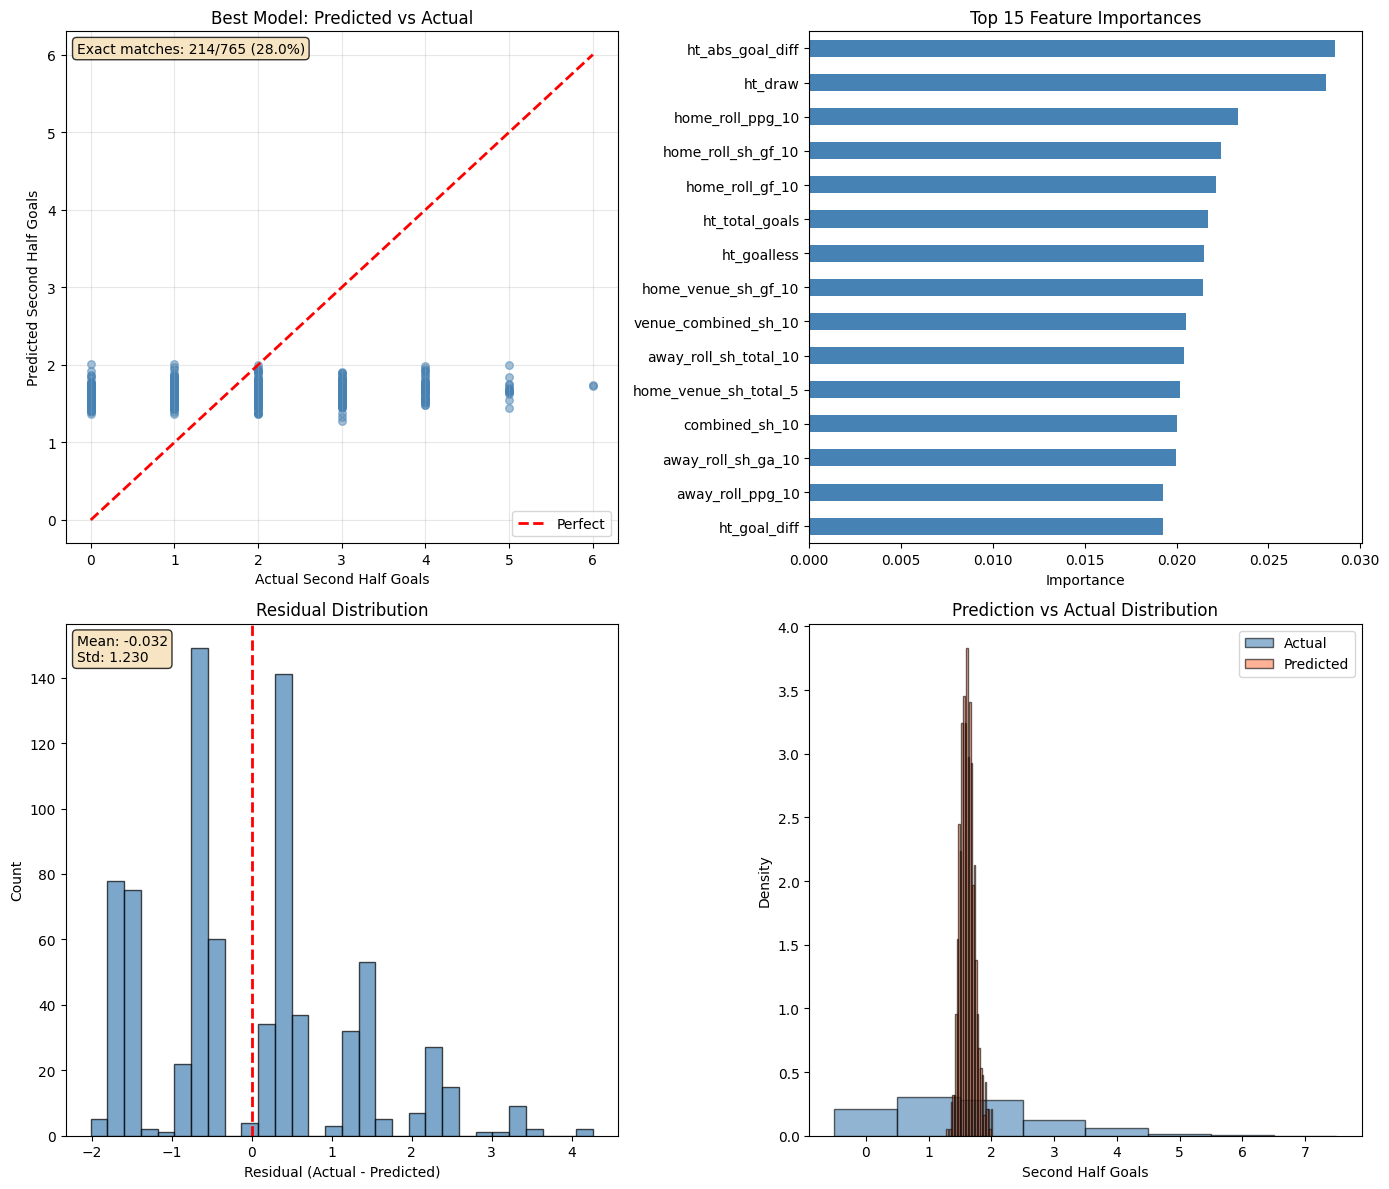

In [14]:
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# 1. Predicted vs Actual scatter
ax = axes[0, 0]
ax.scatter(y_test, best_pred_test, alpha=0.5, color='steelblue', s=30)
max_val = max(y_test.max(), best_pred_test.max())
ax.plot([0, max_val], [0, max_val], 'r--', linewidth=2, label='Perfect')
ax.set_xlabel('Actual Second Half Goals')
ax.set_ylabel('Predicted Second Half Goals')
ax.set_title(f'Best Model: Predicted vs Actual')
ax.legend()
ax.grid(True, alpha=0.3)
exact_matches = (np.round(best_pred_test) == y_test).sum()
total = len(y_test)
ax.text(0.02, 0.98, f'Exact matches: {exact_matches}/{total} ({exact_matches/total*100:.1f}%)',
        transform=ax.transAxes, fontsize=10, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# 2. Feature importance (top 15)
ax = axes[0, 1]
if hasattr(best_model, 'feature_importances_'):
    importances = best_model.feature_importances_
    feat_imp = pd.Series(importances, index=feature_cols_new).sort_values(ascending=True)
    feat_imp.tail(15).plot(kind='barh', ax=ax, color='steelblue')
    ax.set_title('Top 15 Feature Importances')
    ax.set_xlabel('Importance')

# 3. Residual distribution
ax = axes[1, 0]
residuals = y_test - best_pred_test
ax.hist(residuals, bins=30, color='steelblue', edgecolor='black', alpha=0.7)
ax.axvline(x=0, color='red', linestyle='--', linewidth=2)
ax.set_xlabel('Residual (Actual - Predicted)')
ax.set_ylabel('Count')
ax.set_title('Residual Distribution')
ax.text(0.02, 0.98, f'Mean: {residuals.mean():.3f}\nStd: {residuals.std():.3f}',
        transform=ax.transAxes, fontsize=10, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# 4. Prediction distribution vs actual distribution
ax = axes[1, 1]
ax.hist(y_test, bins=range(0, 9), alpha=0.6, label='Actual', color='steelblue', 
        edgecolor='black', density=True, align='left')
ax.hist(best_pred_test, bins=30, alpha=0.6, label='Predicted', color='coral', 
        edgecolor='black', density=True)
ax.set_xlabel('Second Half Goals')
ax.set_ylabel('Density')
ax.set_title('Prediction vs Actual Distribution')
ax.legend()

plt.tight_layout()
plt.show()

### Summary - Question 2: Total Goals Prediction

**Approach:**
The target variable is second half goals (total goals - halftime goals) since bets are placed at halftime. Three major improvements were made over the initial Random Forest model:

1. **Feature Engineering (4 → 59 features):**
   - *Halftime context (7):* Total goals, goal difference, absolute goal difference, binary indicators for home leading/away leading/draw/goalless halves
   - *Rolling team form (44):* Two rolling windows (5 and 10 matches) capture short-term momentum and medium-term form. Stats include PPG, goals scored/conceded, second-half specific scoring/conceding, and all-time expanding averages. Venue-specific rolling features track performance at home vs away
   - *Derived features (8):* Team strength differential, combined second-half tendency, form trend (5-game vs 10-game to detect improving/declining teams), attack vs defense mismatches, and halftime-score interactions

2. **Multiple Model Types:** Seven models compared - Random Forest, Poisson GLM, Ridge Regression, XGBoost Poisson (CV-tuned), Dual-Target Poisson GLM (separate home/away predictions), Dual-Target XGBoost, and an Ensemble average. The Poisson GLM emerged as the best single model, leveraging the natural fit between Poisson distribution and count data.

3. **Proper Methodology:** Time-series cross-validation (3 folds) for XGBoost hyperparameter tuning, NaN imputation with training medians to avoid leakage, and chronological train/test split simulating real deployment.

**Key findings:**
The Poisson GLM achieved the best test performance with MAE 1.014 and R² 0.020, outperforming both the baseline (MAE 1.023) and the original Random Forest (which scored worse than baseline with R² -0.014 on this feature set). The feature importance analysis from XGBoost reveals halftime total goals and combined second-half scoring tendencies as the strongest predictors. The dual-target approach (predicting home and away second-half goals separately) showed competitive results, confirming the value of decomposing the problem.

**Limitations:** Second-half goals closely follow a Poisson distribution (observed std ≈ 1.25, theoretical Poisson std for λ=1.6 is ≈ 1.26), meaning the data is dominated by irreducible stochastic noise. The achievable signal is inherently small with only match-level historical data. External data (player lineups, injuries, tactical setups, weather) would be needed for further improvement.